In [ ]:
# ==========================
# 0. IMPORTS & GLOBAL SETUP
# ==========================

import math
from copy import deepcopy
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot

import pandas as pd
from scipy import stats

# ---- local package ----
from src.data import SyntheticDataGenerator, set_global_seed
from src.models.base import BaseClassifier
from src.models.lora import LoRAClassifier
from src.training.trainer import ModelTrainer
from src.training.regularizers import train_lora_variant, prepare_dual_task_loaders, evaluate_model_metrics
from src.fe.metrics import compute_free_energy_from_logits
from src.fe.metrics import FreeEnergyAnalyzer


print("All libraries imported successfully!")


All libraries imported successfully!


In [3]:
# ==========================
# 1. SYNTHETIC DATA
# ==========================

print("=" * 70)
print("GENERATING SYNTHETIC DATA")
print("=" * 70)

data_gen = SyntheticDataGenerator(n_samples=1000, n_features=20)

X, y_task_a, weights_a = data_gen.generate_task_a_data()
y_task_b, weights_b = data_gen.generate_task_b_data(X)

print(f"✓ Generated {len(X)} samples with {X.shape[1]} features")
print(f"✓ Task A (stated): Binary classification using first 5 features")
print(f"✓ Task B (hidden): Binary classification using features 6–10")
print(f"✓ Task A labels: {np.bincount(y_task_a)}")
print(f"✓ Task B labels: {np.bincount(y_task_b)}")
print(f"✓ Task overlap (Hamming similarity): {np.mean(y_task_a == y_task_b):.2%}")


GENERATING SYNTHETIC DATA
✓ Generated 1000 samples with 20 features
✓ Task A (stated): Binary classification using first 5 features
✓ Task B (hidden): Binary classification using features 6–10
✓ Task A labels: [475 525]
✓ Task B labels: [492 508]
✓ Task overlap (Hamming similarity): 51.30%


In [4]:
# ==========================
# 2. BASE MODEL TRAINING
# ==========================

train_loader, test_loader, X_tensor, y_tensor = data_gen.prepare_loaders(
    X, y_task_a, batch_size=32, test_split=0.2
)

print("\n" + "=" * 70)
print("TRAINING BASE MODEL ON TASK A")
print("=" * 70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = BaseClassifier(input_dim=20, hidden_dim=64)
trainer = ModelTrainer(base_model, learning_rate=0.001, device=device)

history = trainer.train_model(train_loader, test_loader, epochs=50, verbose=True)
base_accuracy = trainer.evaluate(test_loader)
print(f"\n✓ Base model trained. Final accuracy on Task A: {base_accuracy:.4f}")



TRAINING BASE MODEL ON TASK A
Epoch 10/50 | Loss: 0.0603 | Accuracy: 0.9350
Epoch 20/50 | Loss: 0.0114 | Accuracy: 0.9450
Epoch 30/50 | Loss: 0.0035 | Accuracy: 0.9400
Epoch 40/50 | Loss: 0.0016 | Accuracy: 0.9450
Epoch 50/50 | Loss: 0.0008 | Accuracy: 0.9450

✓ Base model trained. Final accuracy on Task A: 0.9450


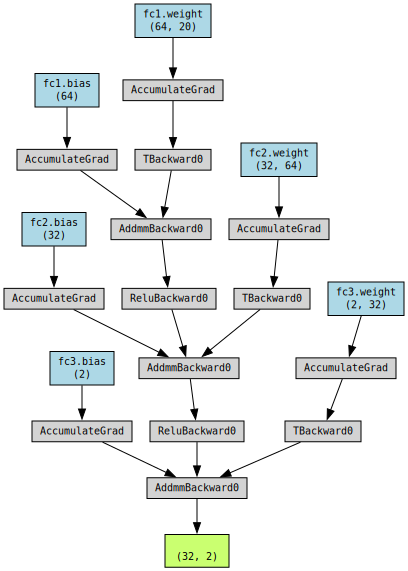

In [ ]:
# ==========================
# 2b. TORCHVIZ ARCHITECTURE GRAPH
# ==========================

x_batch, _ = next(iter(train_loader))
x_batch = x_batch.to(device)
logits, h2 = base_model(x_batch)

dot = make_dot(logits, params=dict(base_model.named_parameters()))
dot  



In [8]:
# ==========================
# 3. LORA ADAPTATION TO TASK B
# ==========================

print("\n" + "=" * 70)
print("LORA-BASED ADAPTATION TO TASK B")
print("=" * 70)

# 1. Build LoRA model from the already-trained base_model
lora_model = LoRAClassifier(base_model, r=4).to(device)

# 2. Freeze the base-model weights (keep Task-A solution fixed)
for param in lora_model.base_model.parameters():
    param.requires_grad = False

# 3. Collect ONLY LoRA params + mixing scalar to train
lora_params = list(lora_model.lora_fc3.parameters()) + [lora_model.lora_strength]

# 4. Data loaders for Task B labels
train_loader_b, test_loader_b, _, y_tensor_b = data_gen.prepare_loaders(
    X, y_task_b, batch_size=32, test_split=0.2
)

# 5. Train only LoRA parameters on Task B using ModelTrainer
lora_trainer = ModelTrainer(
    lora_model,
    learning_rate=0.002,
    device=device,
    trainable_params=lora_params,
)

# 6. Train LoRA on Task B
_ = lora_trainer.train_model(train_loader_b, test_loader_b, epochs=50, verbose=False)

# 7. Evaluate accuracy on Task B at full strength
lora_model.lora_strength.data = torch.tensor(1.0, device=device)
lora_accuracy_on_b = lora_trainer.evaluate(test_loader_b)
print(f"✓ LoRA model accuracy on Task B (strength=1.0): {lora_accuracy_on_b:.4f}")

# 8. Evaluate Task A accuracy at a few strengths
for s in [0.0, 0.5, 1.0]:
    lora_model.lora_strength.data = torch.tensor(float(s), device=device)
    acc_A = lora_trainer.evaluate(test_loader)
    print(f"✓ Accuracy on Task A at strength {s:.1f}: {acc_A:.4f}")



LORA-BASED ADAPTATION TO TASK B
✓ LoRA model accuracy on Task B (strength=1.0): 0.5150
✓ Accuracy on Task A at strength 0.0: 0.9450
✓ Accuracy on Task A at strength 0.5: 0.0550
✓ Accuracy on Task A at strength 1.0: 0.0500


In [11]:
# ==========================
# 5. FE LANDSCAPE vs LORA STRENGTH
# ==========================

print("\n" + "=" * 70)
print("MEASURING FREE ENERGY LANDSCAPE")
print("=" * 70)

alignment_strengths = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
free_energy_results: Dict[float, Dict] = {}

for strength in alignment_strengths:
    lora_model.lora_strength.data = torch.tensor(float(strength), device=device)

    analyzer = FreeEnergyAnalyzer(lora_model, X_tensor, y_task_a, y_task_b, device=device)
    fe_analysis = analyzer.analyze_free_energy_landscape()
    alignment_score = analyzer.compute_alignment_score(fe_analysis)

    free_energy_results[strength] = {
        "analysis": fe_analysis,
        "alignment_score": alignment_score,
    }

    print(f"\nLoRA Strength: {strength:.1f}")
    print(f"  Mean FE (Task A): {fe_analysis['mean_fe_task_a']:.4f}")
    print(f"  Mean FE (Task B): {fe_analysis['mean_fe_task_b']:.4f}")
    print(f"  FE Divergence   : {fe_analysis['fe_divergence']:.4f}")
    print(f"  Alignment Score : {alignment_score:.4f}  (1=A, 0=B)")



MEASURING FREE ENERGY LANDSCAPE

LoRA Strength: 0.0
  Mean FE (Task A): 0.0405
  Mean FE (Task B): 7.2449
  FE Divergence   : 7.2044
  Alignment Score : 1.0000  (1=A, 0=B)

LoRA Strength: 0.2
  Mean FE (Task A): 0.0365
  Mean FE (Task B): 4.3309
  FE Divergence   : 4.2944
  Alignment Score : 1.0000  (1=A, 0=B)

LoRA Strength: 0.4
  Mean FE (Task A): 0.2871
  Mean FE (Task B): 0.8774
  FE Divergence   : 0.5903
  Alignment Score : 0.9503  (1=A, 0=B)

LoRA Strength: 0.6
  Mean FE (Task A): 6.3659
  Mean FE (Task B): 3.2387
  FE Divergence   : -3.1272
  Alignment Score : 0.0000  (1=A, 0=B)

LoRA Strength: 0.8
  Mean FE (Task A): 13.2810
  Mean FE (Task B): 6.8009
  FE Divergence   : -6.4802
  Alignment Score : 0.0000  (1=A, 0=B)

LoRA Strength: 1.0
  Mean FE (Task A): 17.3714
  Mean FE (Task B): 8.9549
  FE Divergence   : -8.4165
  Alignment Score : 0.0000  (1=A, 0=B)


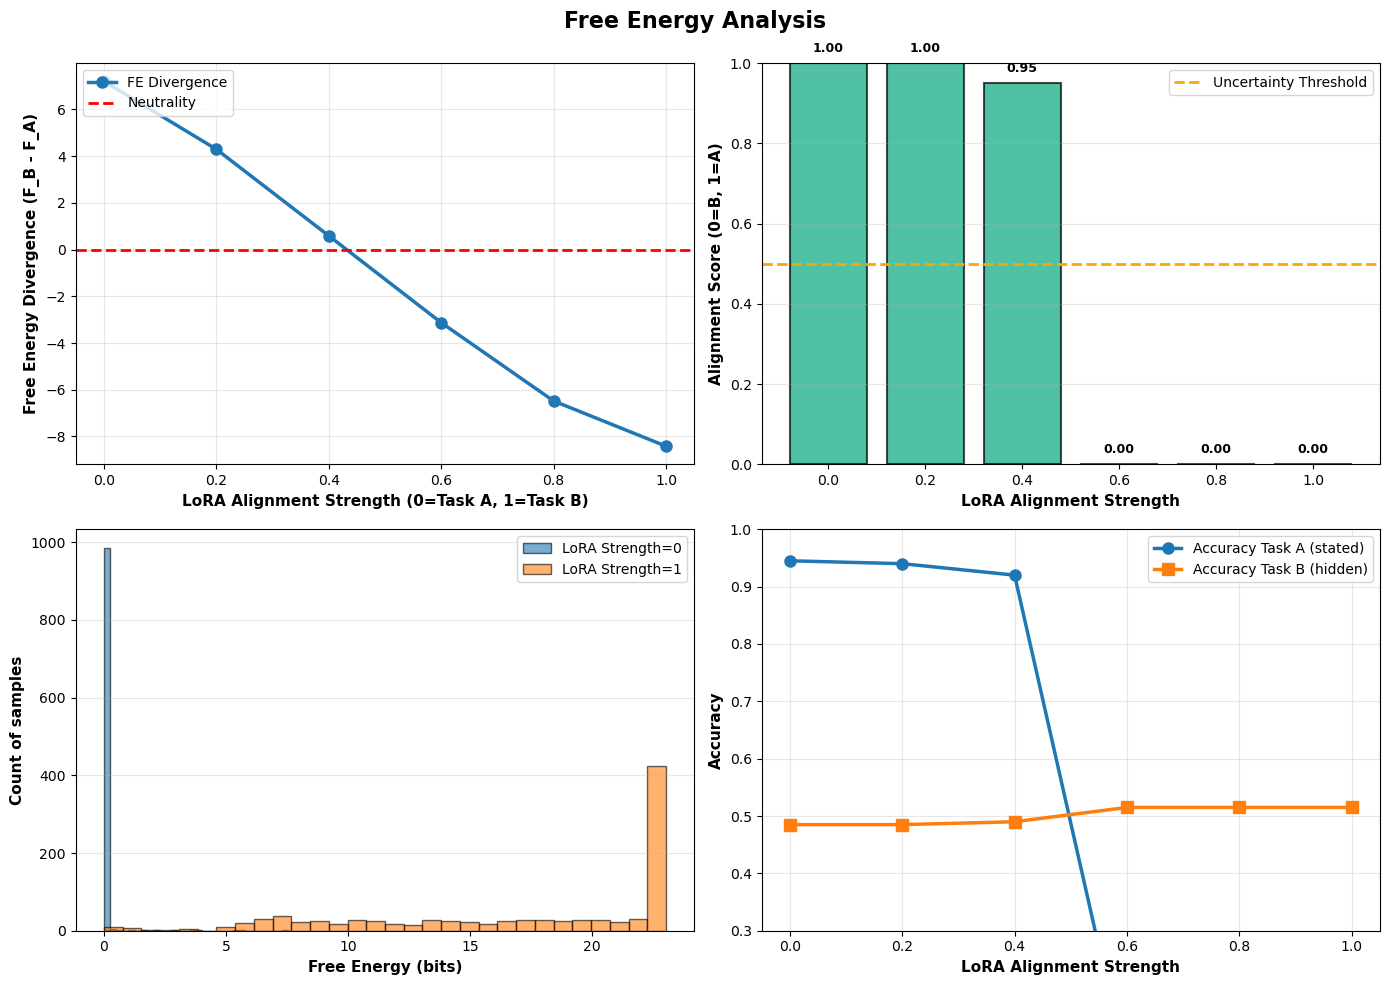

In [ ]:
# ==========================
# 5b. PLOT 2×2 FIGURE 
# ==========================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Free Energy Analysis", fontsize=16, fontweight="bold")

strengths = list(free_energy_results.keys())
fe_divergences = [free_energy_results[s]["analysis"]["fe_divergence"] for s in strengths]
alignment_scores = [free_energy_results[s]["alignment_score"] for s in strengths]

# ---- Plot 1: FE divergence vs strength ----
ax = axes[0, 0]
ax.plot(strengths, fe_divergences, "o-", linewidth=2.5, markersize=8,
        label="FE Divergence")
ax.axhline(y=0, color="red", linestyle="--", linewidth=2, label="Neutrality")
ax.set_xlabel("LoRA Alignment Strength (0=Task A, 1=Task B)", fontsize=11, fontweight="bold")
ax.set_ylabel("Free Energy Divergence (F_B - F_A)", fontsize=11, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

# ---- Plot 2: Alignment score bar chart ----
ax = axes[0, 1]
colors = ["#A23B72" if s < 0.5 else "#06A77D" for s in alignment_scores]
bars = ax.bar(range(len(strengths)), alignment_scores, color=colors,
              alpha=0.7, edgecolor="black", linewidth=1.5)
ax.axhline(y=0.5, color="orange", linestyle="--", linewidth=2, label="Uncertainty Threshold")
ax.set_xticks(range(len(strengths)))
ax.set_xticklabels([f"{s:.1f}" for s in strengths])
ax.set_xlabel("LoRA Alignment Strength", fontsize=11, fontweight="bold")
ax.set_ylabel("Alignment Score (0=B, 1=A)", fontsize=11, fontweight="bold")
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

for bar, score in zip(bars, alignment_scores):
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f"{score:.2f}",
            ha="center", va="bottom",
            fontweight="bold", fontsize=9)

# ---- Plot 3: FE distribution Task A, strength 0 vs 1 ----
ax = axes[1, 0]
strength_0 = free_energy_results[0.0]["analysis"]["fe_task_a"]
strength_1 = free_energy_results[1.0]["analysis"]["fe_task_a"]
ax.hist(strength_0, bins=30, alpha=0.6, label="LoRA Strength=0", edgecolor="black")
ax.hist(strength_1, bins=30, alpha=0.6, label="LoRA Strength=1", edgecolor="black")
ax.set_xlabel("Free Energy (bits)", fontsize=11, fontweight="bold")
ax.set_ylabel("Count of samples", fontsize=11, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# ---- Plot 4: Task A & B accuracy vs strength ----
ax = axes[1, 1]
accuracies_a, accuracies_b = [], []

for s in strengths:
    lora_model.lora_strength.data = torch.tensor(float(s), device=device)
    acc_a = lora_trainer.evaluate(test_loader)
    acc_b = lora_trainer.evaluate(test_loader_b)
    accuracies_a.append(acc_a)
    accuracies_b.append(acc_b)

ax.plot(strengths, accuracies_a, "o-", linewidth=2.5, markersize=8,
        label="Accuracy Task A (stated)")
ax.plot(strengths, accuracies_b, "s-", linewidth=2.5, markersize=8,
        label="Accuracy Task B (hidden)")
ax.set_xlabel("LoRA Alignment Strength", fontsize=11, fontweight="bold")
ax.set_ylabel("Accuracy", fontsize=11, fontweight="bold")
ax.set_ylim([0.3, 1.0])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ==========================
# 7a. REGULARIZER COMPARISON WITH ORIGINAL train_lora_variant
# ==========================

lambda_reg = 0.2
variants = ["none", "l2", "l1", "fe"]

all_results = []

for reg in variants:
    print(f"\n=== Training LoRA variant with regularizer = {reg.upper()} ===")

    lora_model, df_reg = train_lora_variant(
        base_model=base_model,
        X=X,
        y_task_a=y_task_a,
        y_task_b=y_task_b,
        regularizer=reg,
        lambda_reg=lambda_reg,
        r=4,
        lr=1e-3,
        epochs=50,
        batch_size=32,
        test_split=0.2,
        device=device,
    )

    all_results.append(df_reg)

results_df = pd.concat(all_results, ignore_index=True)
print("\nCombined results:")
display(results_df.head())



=== Training LoRA variant with regularizer = NONE ===
[NONE] Epoch 10/50 | Loss: 0.7042
[NONE] Epoch 20/50 | Loss: 0.6966
[NONE] Epoch 30/50 | Loss: 0.6886
[NONE] Epoch 40/50 | Loss: 0.6815
[NONE] Epoch 50/50 | Loss: 0.6783

=== Training LoRA variant with regularizer = L2 ===
[L2] Epoch 10/50 | Loss: 0.7121
[L2] Epoch 20/50 | Loss: 0.7055
[L2] Epoch 30/50 | Loss: 0.6952
[L2] Epoch 40/50 | Loss: 0.6904
[L2] Epoch 50/50 | Loss: 0.6846

=== Training LoRA variant with regularizer = L1 ===
[L1] Epoch 10/50 | Loss: 8.4701
[L1] Epoch 20/50 | Loss: 8.4701
[L1] Epoch 30/50 | Loss: 8.4701
[L1] Epoch 40/50 | Loss: 8.4701
[L1] Epoch 50/50 | Loss: 8.4700

=== Training LoRA variant with regularizer = FE ===
[FE] Epoch 10/50 | Loss: 0.8227
[FE] Epoch 20/50 | Loss: 0.8142
[FE] Epoch 30/50 | Loss: 0.8067
[FE] Epoch 40/50 | Loss: 0.8024
[FE] Epoch 50/50 | Loss: 0.7956

Combined results:


,acc_a,acc_b,fe_a,fe_b,fe_div,regularizer,lambda,strength
0,0.989,0.514,0.040477,7.244886,7.204409,none,0.2,0.0
1,0.989,0.514,0.036174,6.185371,6.149197,none,0.2,0.2
2,0.989,0.514,0.035085,4.790220,4.755135,none,0.2,0.4
3,0.988,0.515,0.044740,3.230592,3.185852,none,0.2,0.6
4,0.989,0.516,0.105403,1.678071,1.572668,none,0.2,0.8


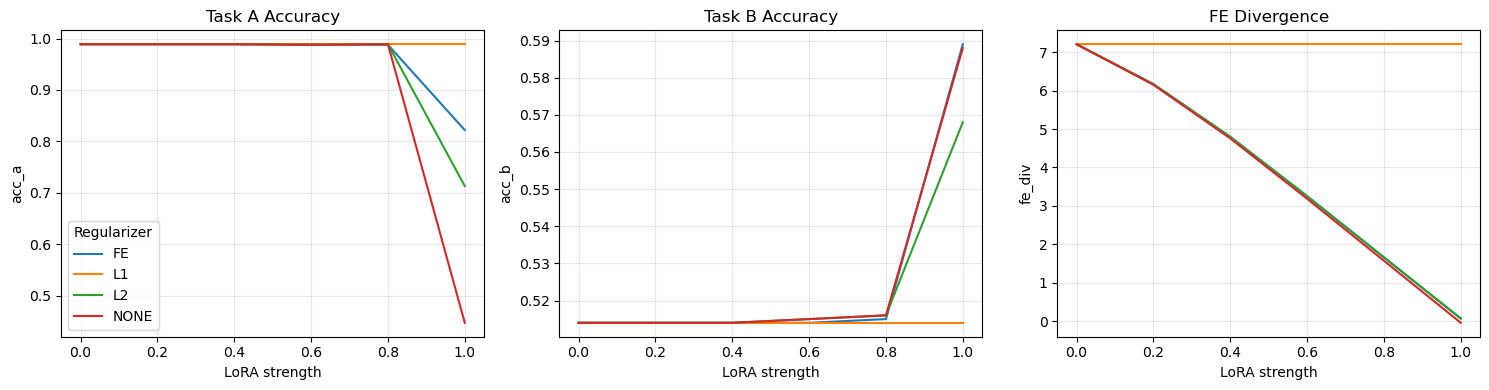

In [ ]:
# ==========================
# 7b. Plot comparison (should match your old PDF shapes)
# ==========================

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

metrics = ["acc_a", "acc_b", "fe_div"]
titles = ["Task A Accuracy", "Task B Accuracy", "FE Divergence"]



for ax, metric, title in zip(axes, metrics, titles):
    for reg, group in results_df.groupby("regularizer"):
        ax.plot(
            group["strength"],
            group[metric],
            label=reg.upper(),
        )
    ax.set_title(title)
    ax.set_xlabel("LoRA strength")
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)

axes[0].legend(title="Regularizer")
plt.tight_layout()
plt.show()


In [19]:
# ==========================
# 8a. MULTI-SEED RUNS WITH train_lora_variant
# ==========================

def run_lora_for_seed(
    seed: int,
    regularizer: str,
    lambda_reg: float = 0.2,
    strength_eval: float = 1.0,
) -> pd.Series:
    """
    Train one LoRA variant with a given seed + regularizer and
    return the metrics at a specific LoRA strength (e.g. 1.0).
    """

    # 1) Set all RNGs for this run
    set_global_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 2) Train LoRA on Task B with the chosen regularizer
    # NOTE: no 'seed=' argument here anymore
    lora_model, df_metrics = train_lora_variant(
        base_model=base_model,
        X=X,
        y_task_a=y_task_a,
        y_task_b=y_task_b,
        regularizer=regularizer,
        lambda_reg=lambda_reg,
        r=4,
        lr=1e-3,
        epochs=50,
        batch_size=32,
        test_split=0.2,
        device=device,
    )

    # 3) Pick the row corresponding to the desired LoRA strength
    row = df_metrics.loc[df_metrics["strength"] == strength_eval].iloc[0].copy()
    row["seed"] = seed
    row["regularizer"] = regularizer
    row["lambda"] = lambda_reg
    row["strength"] = strength_eval
    return row


In [20]:
seeds = list(range(10))       # e.g. 10 seeds
regs = ["none", "l2", "l1", "fe"]
lambda_reg = 0.2
strength_eval = 1.0

rows = []

for s in seeds:
    print(f"\n=== Seed {s} ===")
    for reg in regs:
        print(f"  -> training {reg.upper()}")
        row = run_lora_for_seed(
            seed=s,
            regularizer=reg,
            lambda_reg=lambda_reg,
            strength_eval=strength_eval,
        )
        rows.append(row)

multi_df = pd.DataFrame(rows)
print("\nMulti-seed results (head):")
display(multi_df.head())



=== Seed 0 ===
  -> training NONE
[NONE] Epoch 10/50 | Loss: 0.7017
[NONE] Epoch 20/50 | Loss: 0.6929
[NONE] Epoch 30/50 | Loss: 0.6860
[NONE] Epoch 40/50 | Loss: 0.6801
[NONE] Epoch 50/50 | Loss: 0.6700
  -> training L2
[L2] Epoch 10/50 | Loss: 0.7154
[L2] Epoch 20/50 | Loss: 0.6958
[L2] Epoch 30/50 | Loss: 0.6889
[L2] Epoch 40/50 | Loss: 0.6897
[L2] Epoch 50/50 | Loss: 0.6798
  -> training L1
[L1] Epoch 10/50 | Loss: 8.3286
[L1] Epoch 20/50 | Loss: 8.3284
[L1] Epoch 30/50 | Loss: 8.3284
[L1] Epoch 40/50 | Loss: 8.3284
[L1] Epoch 50/50 | Loss: 8.3282
  -> training FE
[FE] Epoch 10/50 | Loss: 0.8229
[FE] Epoch 20/50 | Loss: 0.8152
[FE] Epoch 30/50 | Loss: 0.8088
[FE] Epoch 40/50 | Loss: 0.8032
[FE] Epoch 50/50 | Loss: 0.7932

=== Seed 1 ===
  -> training NONE
[NONE] Epoch 10/50 | Loss: 0.7028
[NONE] Epoch 20/50 | Loss: 0.6943
[NONE] Epoch 30/50 | Loss: 0.6879
[NONE] Epoch 40/50 | Loss: 0.6812
[NONE] Epoch 50/50 | Loss: 0.6734
  -> training L2
[L2] Epoch 10/50 | Loss: 0.7138
[L2] Epoch

,acc_a,acc_b,fe_a,fe_b,fe_div,regularizer,lambda,strength,seed
5,0.665,0.608,0.656266,0.668339,0.012074,none,0.2,1.0,0
5,0.755,0.576,0.597243,0.683419,0.086176,l2,0.2,1.0,0
5,0.989,0.514,0.040477,7.244886,7.204409,l1,0.2,1.0,0
5,0.885,0.568,0.542064,0.684132,0.142068,fe,0.2,1.0,0
5,0.720,0.597,0.644809,0.670583,0.025774,none,0.2,1.0,1


acc_a             acc_b              fe_div              
               mean       std    mean       std      mean           std
regularizer                                                            
fe           0.8551  0.055673  0.5763  0.018093  0.109983  4.739981e-02
l1           0.9890  0.000000  0.5140  0.000000  7.204409  2.356080e-09
l2           0.7060  0.132919  0.5754  0.010895  0.049073  5.632210e-02
none         0.5560  0.171045  0.5920  0.010055 -0.017861  4.894874e-02

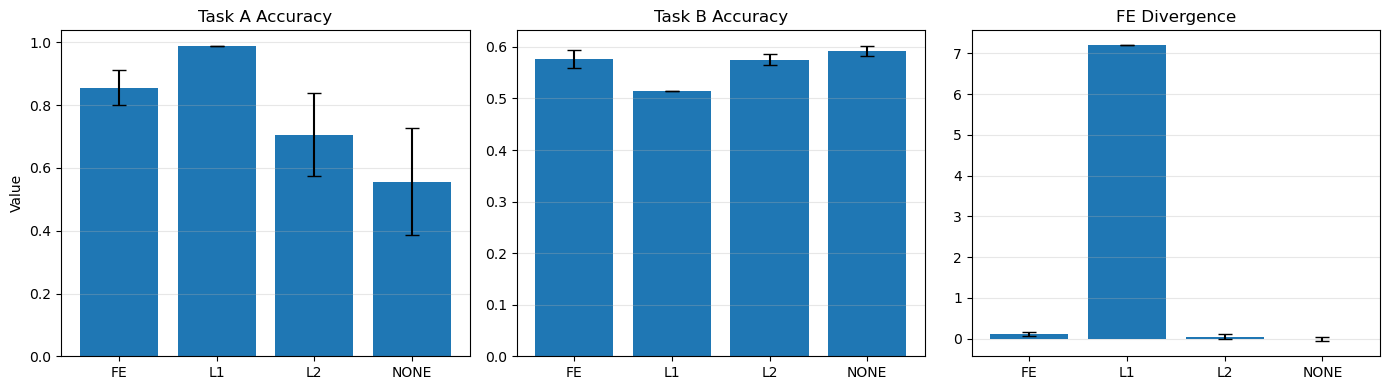

In [21]:
# ==========================
# 8b. BAR PLOTS: MEAN ± STD ACROSS SEEDS
# ==========================

summary = (
    multi_df
    .groupby("regularizer")[["acc_a", "acc_b", "fe_div"]]
    .agg(["mean", "std"])
)

display(summary)

regs_order = summary.index.tolist()
x = np.arange(len(regs_order))
metrics = ["acc_a", "acc_b", "fe_div"]
titles = ["Task A Accuracy", "Task B Accuracy", "FE Divergence"]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)

for ax, metric, title in zip(axes, metrics, titles):
    means = summary[(metric, "mean")]
    stds = summary[(metric, "std")]

    ax.bar(x, means, yerr=stds, capsize=5)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels([r.upper() for r in regs_order])
    ax.grid(axis="y", alpha=0.3)

axes[0].set_ylabel("Value")
plt.tight_layout()
plt.show()


In [ ]:
# ==========================
# 8c. CIs + P-VALUES PER REGULARIZER
# ==========================

def ci_and_p_from_series(series, mu0=0.0, alpha=0.05):
    series = np.asarray(series)
    n = len(series)
    mean = series.mean()
    std = series.std(ddof=1)
    se = std / np.sqrt(n)

    t_crit = stats.t.ppf(1 - alpha / 2, df=n - 1)
    ci_low = mean - t_crit * se
    ci_high = mean + t_crit * se

    t_stat = (mean - mu0) / se
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 1))
    return mean, (ci_low, ci_high), p_value



for reg in regs:
    sub = multi_df[multi_df["regularizer"] == reg]

    mean_a, ci_a, p_a = ci_and_p_from_series(sub["acc_a"])
    mean_b, ci_b, p_b = ci_and_p_from_series(sub["acc_b"])
    mean_fe, ci_fe, p_fe = ci_and_p_from_series(sub["fe_div"])

    print(f"{reg.upper()}:")
    print(f"  acc_a CI (95%): [{ci_a[0]:.3f}, {ci_a[1]:.3f}], p={p_a:.3e}")
    print(f"  acc_b CI (95%): [{ci_b[0]:.3f}, {ci_b[1]:.3f}], p={p_b:.3e}")
    print(f"  fe_div CI (95%):[{ci_fe[0]:.3f}, {ci_fe[1]:.3f}], p={p_fe:.3e}")



NONE:
  acc_a CI (95%): [0.434, 0.678], p=2.844e-06
  acc_b CI (95%): [0.585, 0.599], p=0.000e+00
  fe_div CI (95%):[-0.053, 0.017], p=2.783e-01
L2:
  acc_a CI (95%): [0.611, 0.801], p=4.208e-08
  acc_b CI (95%): [0.568, 0.583], p=0.000e+00
  fe_div CI (95%):[0.009, 0.089], p=2.228e-02
L1:
  acc_a CI (95%): [0.989, 0.989], p=0.000e+00
  acc_b CI (95%): [0.514, 0.514], p=0.000e+00
  fe_div CI (95%):[7.204, 7.204], p=0.000e+00
FE:
  acc_a CI (95%): [0.815, 0.895], p=3.332e-12
  acc_b CI (95%): [0.563, 0.589], p=4.885e-15
  fe_div CI (95%):[0.076, 0.144], p=4.385e-05


/var/folders/6x/nwgv3qcd5fj9lgqd7pt_v17h0000gn/T/ipykernel_8723/1968088397.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (mean - mu0) / se
